# Load the data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp

# from scipy.special import erfinv
from scipy.stats import norm

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
data_train_raw = pd.read_csv('../input/train.csv')
# data_train_raw = data_train_raw.sample(frac=0.01, random_state=0)
data_test_raw = pd.read_csv('../input/test.csv')

In [3]:
data_train_raw.shape

(188318, 132)

# Data transformation

In [14]:
shift = 200
ylog=np.log1p(data_train_raw['loss']+shift)
## ymean=ylog.mean()
## ystd=ylog.std()
ymean=ylog.min()
ystd=ylog.max()-ymean
data_train_raw['loss_g']=(ylog-ymean)/ystd
# data_train_raw['loss_g']=ylog

In [15]:
# clean outliers in training data
lossMean = data_train_raw['loss_g'].mean()
lossStd = data_train_raw['loss_g'].std()
print('Mean of log1py: {}'.format(lossMean))
print('Std of log1py: {}'.format(lossStd))
lbound = lossMean-3.0*lossStd
ubound = lossMean+3.0*lossStd
print('Lower clipping bound: {}\nUpper clipping bound: {}'.format(lbound, ubound))
data_train_raw = data_train_raw[(data_train_raw['loss_g']>=lbound) & (data_train_raw['loss_g']<=ubound)]
print('Shape of cleaned data: {}'.format(data_train_raw.shape))

Mean of log1py: 0.456754710754
Std of log1py: 0.180333589104
Lower clipping bound: -0.0842460565564
Upper clipping bound: 0.997755478065
Shape of cleaned data: (187771, 134)


In [16]:
# # rescale cleaned data
# ymean=data_train_raw['loss_g'].min()
# ystd=data_train_raw['loss_g'].max()
# data_train_raw['loss_g']=(ylog-ymean)/(ystd-ymean)

In [17]:
def ToUniform(y):
    z = norm.cdf(-y/np.sqrt(2))
    return z
def UniformToGauss(z):
    return -np.sqrt(2)*norm.ppf(z)*ystd+ymean
# def BackToOriginal(z):
#     return np.exp(UniformToGauss(z))

data_train_raw['loss_u']=ToUniform(data_train_raw['loss_g'])

def lossRestore(logloss, ymean, ystd):
    loss = np.expm1(logloss*ystd+ymean)
    return loss

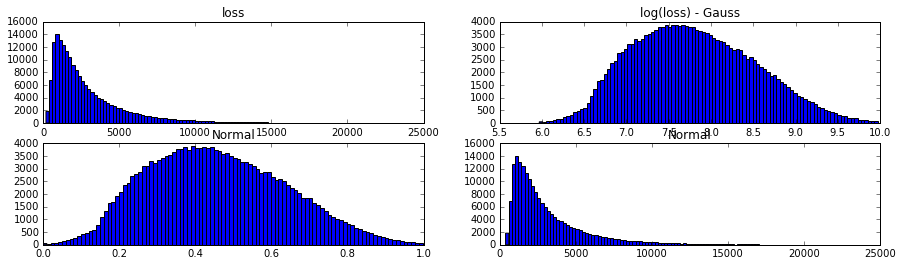

In [18]:
plt.figure(figsize=(15,4))

plt.subplot(2,2,1)
plt.hist(data_train_raw['loss'],100)
plt.title('loss');

plt.subplot(2,2,2)
plt.hist(ylog,100)
plt.title('log(loss) - Gauss');

plt.subplot(2,2,3)
plt.hist(data_train_raw['loss_g'],100)
plt.title('Normal');

plt.subplot(2,2,4)
plt.hist(lossRestore(data_train_raw['loss_g'],ymean,ystd),100)
plt.title('Normal');

# Data preparation - labeling encoder

In [19]:
# save label in a seperate serie
labelSs = data_train_raw['loss_g'] 
trainDf = data_train_raw.drop(['id','loss','loss_g','loss_u'],axis=1)
subId = data_test_raw['id']
testDf = data_test_raw.drop(['id'],axis=1)

print('trainDf has features from the raw data:\n{}'.format(trainDf.columns))
print('testDf has features from the raw data:\n{}'.format(testDf.columns))

trainDf has features from the raw data:
Index([u'cat1', u'cat2', u'cat3', u'cat4', u'cat5', u'cat6', u'cat7', u'cat8',
       u'cat9', u'cat10',
       ...
       u'cont5', u'cont6', u'cont7', u'cont8', u'cont9', u'cont10', u'cont11',
       u'cont12', u'cont13', u'cont14'],
      dtype='object', length=130)
testDf has features from the raw data:
Index([u'cat1', u'cat2', u'cat3', u'cat4', u'cat5', u'cat6', u'cat7', u'cat8',
       u'cat9', u'cat10',
       ...
       u'cont5', u'cont6', u'cont7', u'cont8', u'cont9', u'cont10', u'cont11',
       u'cont12', u'cont13', u'cont14'],
      dtype='object', length=130)


In [20]:
dataAll = pd.concat([trainDf,testDf])
dataCatAll = dataAll.select_dtypes(include=['object'])
dataFltAll = dataAll.select_dtypes(include=['float64'])
print('the stacked data\'s dimension are:\n{}'.format(dataAll.shape))
print('{} of which are categorical'.format(dataCatAll.shape))
print('{} of which are continuous'.format(dataFltAll.shape))

the stacked data's dimension are:
(313317, 130)
(313317, 116) of which are categorical
(313317, 14) of which are continuous


In [21]:
dataCatAll.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,A,B,A,B,A,A,A,A,B,A,...,J,G,BU,BC,C,AS,S,A,O,LB
1,A,B,A,A,A,A,A,A,B,B,...,K,K,BI,CQ,A,AV,BM,A,O,DP
2,A,B,A,A,B,A,A,A,B,B,...,F,A,AB,DK,A,C,AF,A,I,GK
3,B,B,A,B,A,A,A,A,B,A,...,K,K,BI,CS,C,N,AE,A,O,DJ
4,A,B,A,B,A,A,A,A,B,B,...,G,B,H,C,C,Y,BM,A,K,CK


In [22]:
LevelList = {'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'}
def LetterRep(x,LevelList):
    if x in LevelList:
        x = '0'+x
    return x
        
dataCatAll = dataCatAll.applymap(lambda x: LetterRep(x,LevelList))
dataCatAll.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,0A,0B,0A,0B,0A,0A,0A,0A,0B,0A,...,0J,0G,BU,BC,0C,AS,0S,0A,0O,LB
1,0A,0B,0A,0A,0A,0A,0A,0A,0B,0B,...,0K,0K,BI,CQ,0A,AV,BM,0A,0O,DP
2,0A,0B,0A,0A,0B,0A,0A,0A,0B,0B,...,0F,0A,AB,DK,0A,0C,AF,0A,0I,GK
3,0B,0B,0A,0B,0A,0A,0A,0A,0B,0A,...,0K,0K,BI,CS,0C,0N,AE,0A,0O,DJ
4,0A,0B,0A,0B,0A,0A,0A,0A,0B,0B,...,0G,0B,0H,0C,0C,0Y,BM,0A,0K,CK


In [23]:
features = dataCatAll.columns[1:]
dataCatAll_2 = dataCatAll[features]
cats = [feature for feature in features if feature.startswith('cat')]
for feat in cats:
    dataCatAll_2[feat] = pd.factorize(dataCatAll_2[feat], sort=True)[0]
dataCatAll_2.head()
# le.classes_

/home/ec2-user/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,1,0,1,0,0,0,0,1,0,1,...,9,6,68,49,2,43,17,0,14,299
1,1,0,0,0,0,0,0,1,1,0,...,10,10,56,87,0,46,60,0,14,114
2,1,0,0,1,0,0,0,1,1,1,...,5,0,25,106,0,2,28,0,8,184
3,1,0,1,0,0,0,0,1,0,0,...,10,10,56,89,2,13,27,0,14,108
4,1,0,1,0,0,0,0,1,1,0,...,6,1,7,2,2,24,60,0,10,84


In [24]:
dataCatAll = dataCatAll.drop(features,axis=1)
dataCatAll.head()

,cat1
0,0A
1,0A
2,0A
3,0B
4,0A


In [25]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for col in dataCatAll.columns:
    if (col.find('cat') !=-1):
#        print(col)
        dataCatAll[col]=le.fit_transform(dataCatAll[col])
#         dataAll[col] = dataAll[col].map(lambda s: '<unknown>' if s not in le.classes_ else s)
#         le.classes_ = np.append(le.classes_, '<unknown>')
#         data_test_raw[str(col+'_numerical')]=le.transform(data_test_raw[col])
print(dataCatAll.columns)


Index([u'cat1'], dtype='object')


In [26]:
dataCatAll.head()

,cat1
0,0
1,0
2,0
3,1
4,0


In [27]:
# rescale the labeled categorical data
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
x_catAll_2 = mms.fit_transform(dataCatAll_2)

In [28]:
print(x_catAll_2.shape)
x_catAll_2

(313317, 115)


array([[ 1.        ,  0.        ,  1.        , ...,  0.        ,
         0.63636364,  0.86416185],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.63636364,  0.32947977],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.36363636,  0.53179191],
       ..., 
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.68181818,  0.93063584],
       [ 0.        ,  0.        ,  0.        , ...,  0.22222222,
         0.63636364,  0.31213873],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.5       ,  0.26300578]])

# restore to x_trainDf and x_testDf - skipped

In [29]:
# # hstack all the features and .
# x_allDf = pd.concat([dataCatAll,dataFltAll],axis=1)
# x_means = x_allDf.mean()
# x_stds = x_allDf.std()
# x_allDf = (x_allDf-x_means)/x_stds
# x_allDf.head()

In [30]:
# x_Train = x_allDf.iloc[0:len(labelSs),:]
# x_Test = x_allDf.iloc[len(labelSs):,:]
# y_Train = labelSs

# one-hot-encoding - skipped in order to keep the alphabetical order

In [31]:
# one-hot-encoding the categorical features
enc = preprocessing.OneHotEncoder()
x_catAll = enc.fit_transform(dataCatAll)
print(x_catAll.shape)

(313317, 2)


# split x_train and x_test

In [32]:
# split x_train and x_test
x_Train = sp.sparse.hstack((x_catAll[0:len(labelSs),:],x_catAll_2[0:len(labelSs),:],sp.sparse.csr_matrix(dataFltAll.as_matrix())[0:len(labelSs),:]))
x_Test = sp.sparse.hstack((x_catAll[len(labelSs):,:],x_catAll_2[len(labelSs):,:],sp.sparse.csr_matrix(dataFltAll.as_matrix())[len(labelSs):,:]))
y_Train = labelSs.values

# check the dimension of prepared data

In [33]:
print(x_Test.shape)
print(x_Train.shape)
print(y_Train.shape)

(125546, 131)
(187771, 131)
(187771,)


# splite the training data for valication

In [34]:
from sklearn import cross_validation
val_size = 0.2
seed = 0
x_train, x_val, y_train, y_val = cross_validation.train_test_split(x_Train, y_Train, test_size=val_size, random_state=seed)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

/home/ec2-user/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


(150216, 131)
(150216,)
(37555, 131)
(37555,)


In [35]:
del x_Train
del y_Train
del x_catAll
del dataCatAll
# del trainDf
# del testDf

# Model Fitting

In [36]:
from sklearn.metrics import mean_absolute_error
y_pred = []
y_pred_val = []
submission = pd.read_csv('../input/sample_submission.csv')

In [37]:
testList = ['XGBoostTrees', 'AdaBoosting', 'MLPRegressor','Ensemble']

### Ridge Regression

In [38]:
# from sklearn.linear_model import RidgeCV
# # from sklearn.linear_model import Ridge

In [39]:
# cv = 3
# # alphas = (1e-2,1e-1,1,1e1,1e2)
# # alphas = (5,20,30,40)
# alphas = [10]
# regCV = RidgeCV(cv=cv,alphas = alphas)
# regCV.fit(x_train,y_train)
# print('alpha: {}\n'.format(regCV.alpha_))
# # print('cv_values_: {}\n'.format(regCV.cv_values_))

In [40]:
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(regCV.predict(x_val),ymean,ystd)))

In [41]:
# y_pred_i = lossRestore(regCV.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(regCV.predict(x_val),ymean,ystd))

### Lasso Regression

In [42]:
# from sklearn.linear_model import LassoCV

In [43]:
# cv = 3
# # alphas = (1e-3,1e-2,1e-1,1,1e1,1e2,1e3)
# # alphas = (0.0005,0.0007,0.001,0.003,0.005)
# # alphas = [0.00005,0.0001,0.0003,0.0005]
# alphas = [0.00005]
# LassoCV = LassoCV(cv=cv,alphas = alphas)
# LassoCV.fit(x_train,y_train)
# print('alpha: {}\n'.format(LassoCV.alpha_))

In [44]:
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(LassoCV.predict(x_val),ymean,ystd)))

In [45]:
# y_pred_i = lossRestore(LassoCV.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(LassoCV.predict(x_val),ymean,ystd))

### Skipped - Random Forest - using mse rather than mae, because the mae implementation is much slower.

In [46]:
# from sklearn.ensemble import RandomForestRegressor

In [47]:
# criterion = 'mse'
# n_estimators = [30]
# err = 999999999
# n_estimator = 0
# random_state = 0
# for n_est in n_estimators:
#     tmpRFReg = RandomForestRegressor(n_estimators = n_est,criterion = criterion, random_state = random_state)
#     tmpRFReg.fit(x_train,y_train)
#     err_i = mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(tmpRFReg.predict(x_val),ymean,ystd))
#     print(err_i)
#     if err_i < err:
#         RFReg = tmpRFReg
#         n_estimator = n_est
#         err = err_i

In [48]:
# print('n_estimator = {}'.format(n_estimator))
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(RFReg.predict(x_val),ymean,ystd)))

In [49]:
# y_pred_i = lossRestore(RFReg.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(RFReg.predict(x_val),ymean,ystd))

### XGBoost Trees

In [50]:
import xgboost as xgb

In [51]:
d_train_xgb = xgb.DMatrix(x_train.tocsc(),label=y_train)
d_val_xgb = xgb.DMatrix(x_val.tocsc(),label = y_val)
x_val_xgb = xgb.DMatrix(x_val.tocsc())
d_test_xgb = xgb.DMatrix(x_Test.tocsc())

In [54]:
num_round = 2950

# params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':0,'eta':0.05,'min_child_weight':0}# 1136, 500 rounds
# params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':0, \
#           'eta':0.05,'min_child_weight':0,'subsample':0.8}# 1124, 2000 rounds
params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':0, \
          'eta':0.02,'min_child_weight':0,'subsample':0.8}# 1124, 2500 rounds
# params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':0, \
#           'eta':0.01,'min_child_weight':0,'subsample':0.8}# 1124, 2500 rounds

watchlist  = [(d_val_xgb,'eval'), (d_train_xgb,'train')]
gbt = xgb.train(params, d_train_xgb,num_round,watchlist)

[0]	eval-mae:0.152531	train-mae:0.152384
[1]	eval-mae:0.15111	train-mae:0.150961
[2]	eval-mae:0.149734	train-mae:0.149583
[3]	eval-mae:0.148404	train-mae:0.148252
[4]	eval-mae:0.147105	train-mae:0.146956
[5]	eval-mae:0.14586	train-mae:0.145713
[6]	eval-mae:0.14463	train-mae:0.144485
[7]	eval-mae:0.143467	train-mae:0.143324
[8]	eval-mae:0.142325	train-mae:0.142183
[9]	eval-mae:0.141207	train-mae:0.141071
[10]	eval-mae:0.140125	train-mae:0.139998
[11]	eval-mae:0.139072	train-mae:0.138948
[12]	eval-mae:0.138029	train-mae:0.13791
[13]	eval-mae:0.137034	train-mae:0.136919
[14]	eval-mae:0.13606	train-mae:0.135952
[15]	eval-mae:0.135101	train-mae:0.135002
[16]	eval-mae:0.134201	train-mae:0.134109
[17]	eval-mae:0.133312	train-mae:0.133226
[18]	eval-mae:0.132435	train-mae:0.132355
[19]	eval-mae:0.131609	train-mae:0.131533
[20]	eval-mae:0.130797	train-mae:0.130728
[21]	eval-mae:0.130001	train-mae:0.12994
[22]	eval-mae:0.12923	train-mae:0.129178
[23]	eval-mae:0.128481	train-mae:0.128431
[24]	eval

In [55]:
print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(gbt.predict(x_val_xgb),ymean,ystd)))

1110.82719183


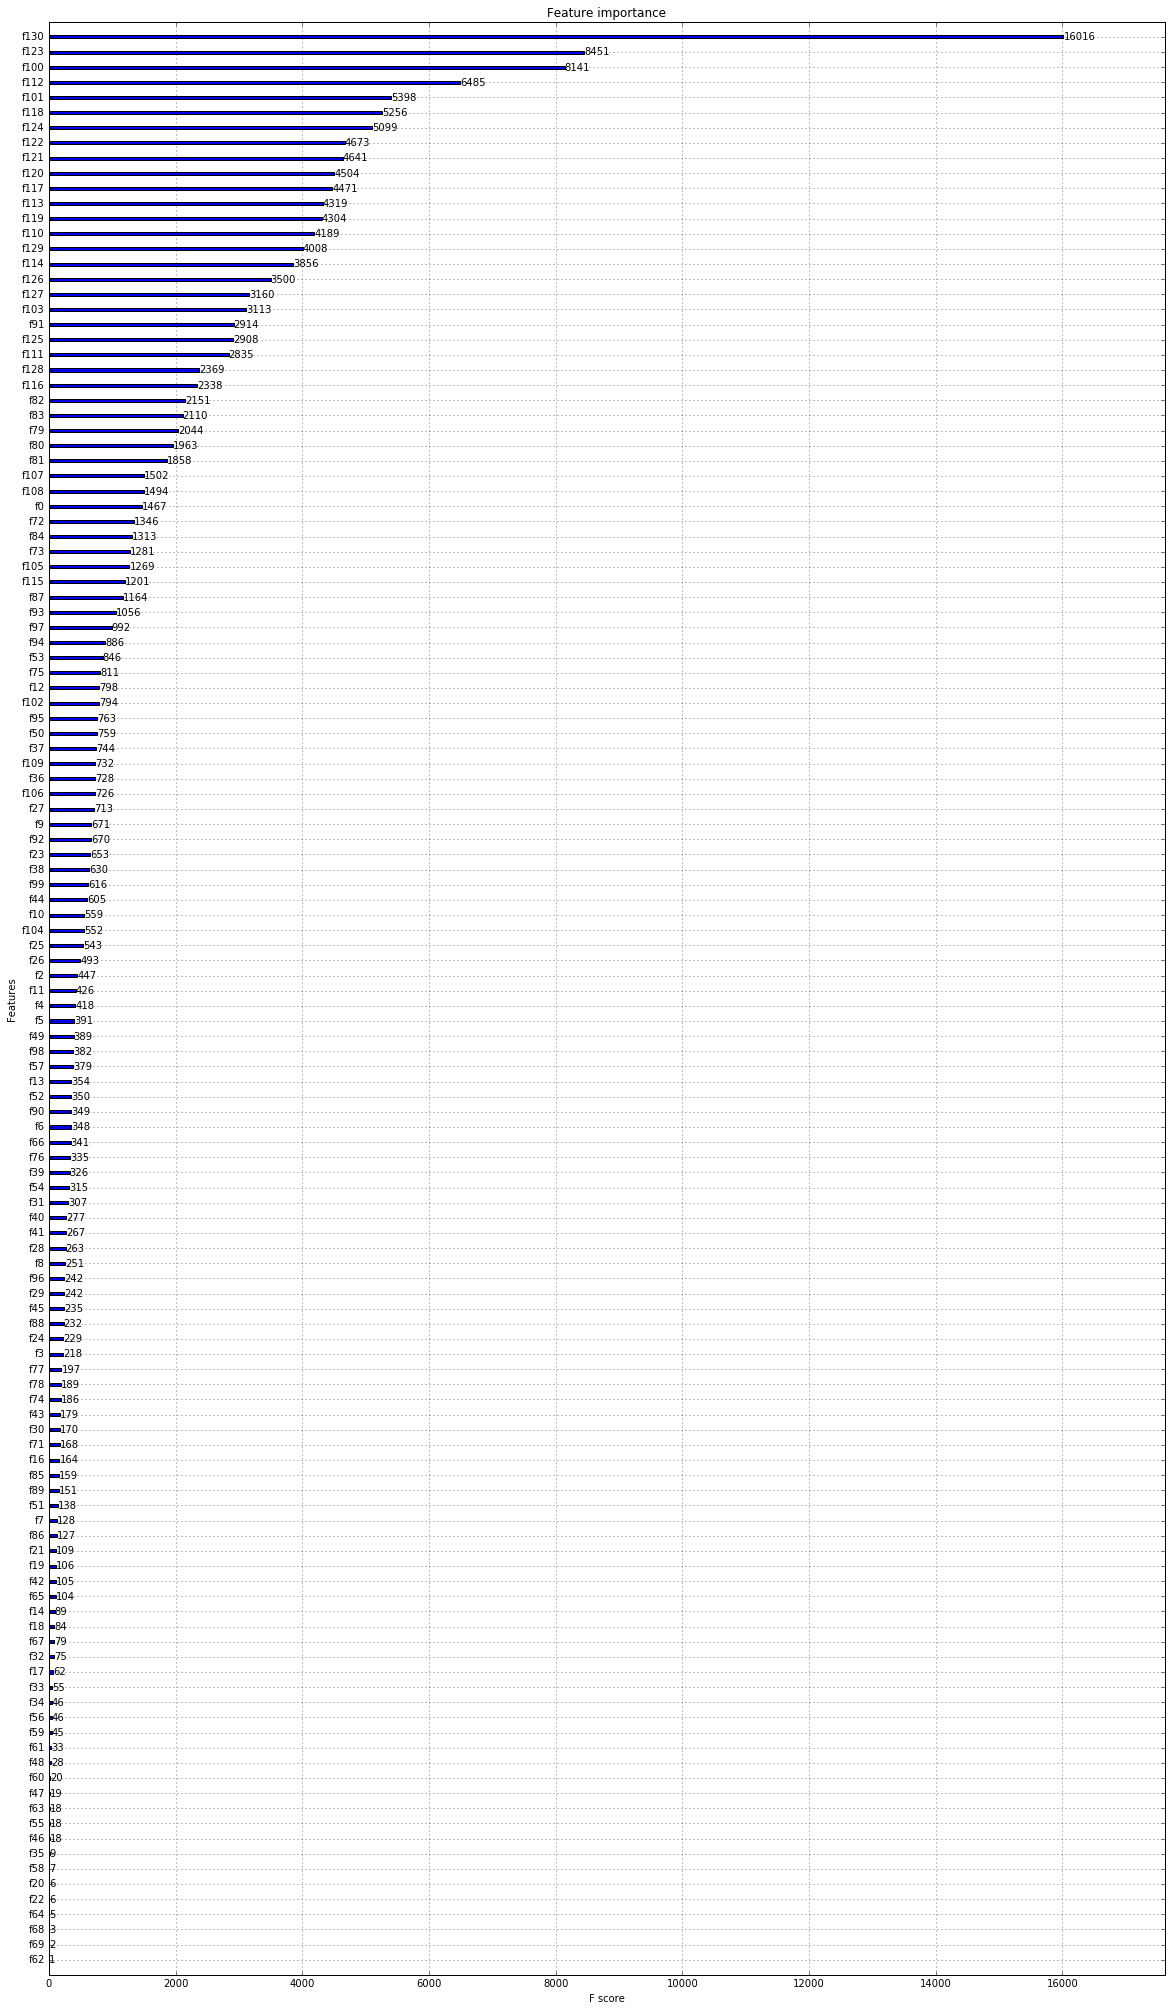

In [56]:
fig = plt.figure(figsize=(20,35))

xgb.plot_importance(gbt,ax = fig.gca() )

In [57]:
y_pred_i = lossRestore(gbt.predict(d_test_xgb),ymean,ystd)
y_pred.append(y_pred_i-shift)
y_pred_val.append(lossRestore(gbt.predict(x_val_xgb),ymean,ystd)-shift)

### AdaBoost Regression

In [58]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Ridge

In [59]:
n_estimators = [7,15,30, 60, 90, 120]
# n_estimators = [10,20,30,40]
# n_estimators = [6]
base_estimator = Ridge(alpha = 40)
err = 999999999
n_estimator = 0
random_state = 0
for n_est in n_estimators:
#     tmpAdReg = AdaBoostRegressor(n_estimators = n_est, random_state = random_state,base_estimator = base_estimator)
    tmpAdReg = AdaBoostRegressor(n_estimators = n_est, random_state = random_state)
    tmpAdReg.fit(x_train,y_train)
    err_i = mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(tmpAdReg.predict(x_val),ymean,ystd))
    print(err_i)
    if err_i < err:
        AdReg = tmpAdReg
        n_estimator = n_est
        err = err_i

1400.56018509
1420.93097271
1448.80383916
1478.08975357
1479.2348188
1479.2348188


In [60]:
print('n_estimator = {}'.format(n_estimator))
print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(AdReg.predict(x_val),ymean,ystd)))

n_estimator = 7
1400.56018509


In [61]:
y_pred_i = lossRestore(AdReg.predict(x_Test),ymean,ystd)
y_pred.append(y_pred_i-shift)
y_pred_val.append(lossRestore(AdReg.predict(x_val),ymean,ystd)-shift)

### Skipped - K Nearest Neighbors

In [62]:
# from sklearn.neighbors import KNeighborsRegressor

In [63]:
# n_neighbors = [5, 10, 15]
# weights = 'distance'
# err = 999999999
# n_nns = 0
# # random_state = 0
# for n_nn in n_neighbors:
#     tmpKNReg = KNeighborsRegressor(n_neighbors = n_nn,weights = weights)
#     tmpKNReg.fit(x_train,y_train)
#     err_i = mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(tmpKNReg.predict(x_val),ymean,ystd))
#     print(err_i)
#     if err_i < err:
#         KNReg = tmpKNReg
#         n_nns = n_nn
#         err = err_i

In [64]:
# print('n_neighbors = {}'.format(n_nns))
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(KNReg.predict(x_val),ymean,ystd)))

In [65]:
# y_pred_i = lossRestore(KNReg.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(KNReg.predict(x_val),ymean,ystd))

### Linear SVR

In [66]:
# from sklearn.svm import LinearSVR

In [67]:
# # SVReg = svm.SVR(kernel = 'rbf')
# # SVReg.fit(x_train,y_train)
# SVReg = LinearSVR(C=0.5)
# SVReg.fit(x_train,y_train)

In [68]:
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(SVReg.predict(x_val),ymean,ystd)))

In [69]:
# y_pred_i = lossRestore(SVReg.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(SVReg.predict(x_val),ymean,ystd))

### MLP Regressor

In [70]:
from sklearn.neural_network import MLPRegressor

In [71]:
MLPReg = MLPRegressor(alpha = 1e-5, hidden_layer_sizes = (35,3),random_state=0,early_stopping=True)
MLPReg.fit(x_train,y_train)

MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(35, 3), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [72]:
print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(MLPReg.predict(x_val),ymean,ystd)))

1162.67191323


In [73]:
y_pred_i = lossRestore(MLPReg.predict(x_Test),ymean,ystd)
y_pred.append(y_pred_i-shift)
y_pred_val.append(lossRestore(MLPReg.predict(x_val),ymean,ystd)-shift)

# save files for submission

In [74]:
# ensemble the results
y_pred.append(np.ndarray.mean(np.vstack(y_pred).T,axis=1))

# ensembled y_val
print('The loss of the ensembled result:')
y_pred_val_en = np.ndarray.mean(np.vstack(y_pred_val).T,axis=1)
mean_absolute_error(lossRestore(y_val,ymean,ystd),y_pred_val_en)

The loss of the ensembled result:


1179.393040484227

In [75]:
# Save all the predictions for submission
for i,stri in enumerate(testList):
    submission['id'] = subId
    submission['loss']=pd.Series(data=y_pred[i])
    submission.to_csv('../output/'+stri+'.csv',index=False)

In [76]:
from sklearn.externals import joblib
joblib.dump([regCV, gbt, AdReg, MLPReg, y_pred, y_pred_val, x_train, x_val, y_train, y_val, x_Test]
            ,'../output/models-raw-features-rescale-loss-shift.pkl',compress=3) 

# clf = joblib.load('filename.pkl') 

NameError: name 'regCV' is not defined

In [ ]:
testList
